In [1]:
#####
# imports
#####

import pandas as pd
import numpy as np
import albumentations as alb
import matplotlib.pyplot as plt
import os 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from PIL import Image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation
from tensorflow.keras.regularizers import l2
import albumentations as alb

In [87]:
# We are trying to build a classifier capable of identifying 4 different health states of cassava plants.
# Let's look at some examples.

0 - Cassava Bacterial Blight (CBB)


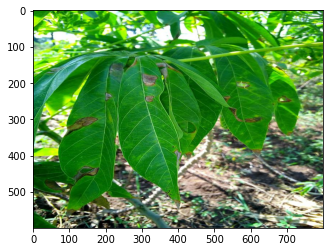

CBB destroys the greatest amount of cassava world wide.
Symptoms include brown spots on the leaves and wilting.

1 - Cassava Brown Streak Disease (CBSD)


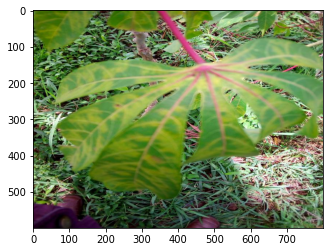

CBSD causes large irregular yellowish necrotic areas on the leaves.

2 - Cassava Green Mottle (CGM)


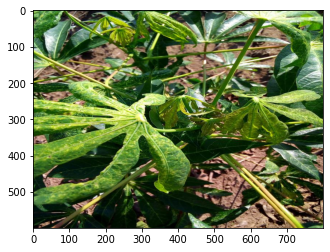

CGM causes light spotting that can distort the leaves.

3 - Cassava Mosaic Disease(CMD)


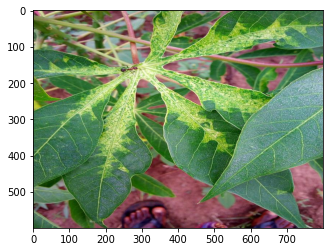

CMD causes lighter spots that can follow a mosaic like pattern. It can distort the leaves.

4 - Healthy


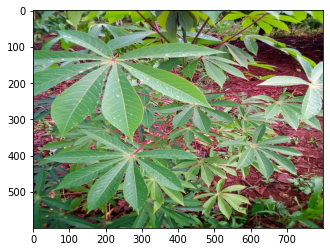

In [137]:
# A short look at the different dieseases:

print('0 - Cassava Bacterial Blight (CBB)')
img = Image.open('../cassava_data/train_images/1012426959.jpg')
plt.imshow(img)
plt.show()
print('CBB destroys the greatest amount of cassava world wide.')
print('Symptoms include brown spots on the leaves and wilting.')
print('')

print('1 - Cassava Brown Streak Disease (CBSD)')
img = Image.open('../cassava_data/train_images/1020936674.jpg')
plt.imshow(img)
plt.show()
print('CBSD causes large irregular yellowish necrotic areas on the leaves.')
print('')

print('2 - Cassava Green Mottle (CGM)')
img = Image.open('../cassava_data/train_images/2586512285.jpg')
plt.imshow(img)
plt.show()
print('CGM causes light spotting that can distort the leaves.')
print('')

print('3 - Cassava Mosaic Disease(CMD)')
img = Image.open('../cassava_data/train_images/2584392391.jpg')
plt.imshow(img)
plt.show()
print('CMD causes lighter spots that can follow a mosaic like pattern. It can distort the leaves.')
print('')

print('4 - Healthy')
img = Image.open('../cassava_data/train_images/2599716622.jpg')
plt.imshow(img)
plt.show()

In [2]:
#####
# define constants and load basic data
#####

# load dataframe and define image directory
leaf_info = pd.read_csv('../cassava_data/train.csv')
leaf_image_directory = '../cassava_data/train_images'

# define the categories to be classified
leaf_disease_categories = ['0', '1', '2', '3', '4']

# change data types
leaf_info['label'] = leaf_info['label'].astype(str)
leaf_info['image_id'] = leaf_info['image_id'].astype(str)

# define basic parameters
dropout_rate = 0.3
batch_size = 2
train_input_shape = (512,512,3)
l2_penalty = 0.0001

Original image:


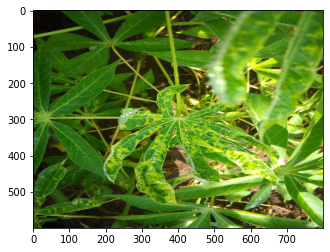

Augmented image:


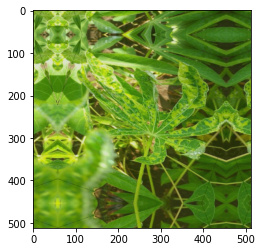

In [3]:
#####
# data augmentations
#####

# Create a augmentations layer that happens before the resize function of Keras ImageDataGenerator
# Cutting out a smaller frame from a bigger picture could improve accuracy with cassava leaf disease 
# classification.
# A lot of the Pictures show singular diseased leaves and many healthy ones! A zoom on those diseased
# leaves with high enough resolution could help with accuracy.
data_augmentation_layers = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomCrop(height=train_input_shape[0], width=train_input_shape[1]),
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.15),
        layers.experimental.preprocessing.RandomZoom((-0.3, 0.3)),
        layers.experimental.preprocessing.RandomContrast((0.3,0.3)),
    ]
)

print('Original image:')
img = Image.open('../cassava_data/train_images/4222242.jpg')
plt.imshow(img)
plt.show()

print('Augmented image:')
img = tf.expand_dims(np.array(img), 0)
augmented_image = data_augmentation_layers(img)
plt.imshow(augmented_image[0])
plt.show()

In [4]:
#####
# image data generators
#####

train_datagen = ImageDataGenerator(
                                   #preprocessing_function=augment,
                                   validation_split=0.2,
                                  )

train_generator = train_datagen.flow_from_dataframe(
                                                    directory=leaf_image_directory,
                                                    dataframe=leaf_info,
                                                    x_col='image_id',
                                                    y_col='label',
                                                    target_size=train_input_shape[0:2],
                                                    color_mode="rgb",
                                                    #class_mode='categorical',
                                                    classes=leaf_disease_categories,
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    class_mode="sparse",
                                                   )

valid_generator = train_datagen.flow_from_dataframe(
                                                    directory=leaf_image_directory,
                                                    dataframe=leaf_info,
                                                    x_col='image_id',
                                                    y_col='label',
                                                    target_size=train_input_shape[0:2],
                                                    color_mode="rgb",
                                                    #class_mode='categorical',
                                                    classes=leaf_disease_categories,
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    class_mode="sparse"
                                                   )

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [5]:
#####
# callbacks
#####

# Let us automatically reduce the learning rate when val_loss stops improving.
# And we want to save the best Model so we can use it later.
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint(filepath='best_model.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

In [6]:
#####
# create model
#####

# We will be using an EfficientNet. As the name suggests it is pretty efficient for the GPU power it needs.
# B0, the smallest of the EfficientNets, first.
# Parameters are:
# 300x300 images, cropped, rotated, flipped, random zoom and random contrast
# with learning rate reduction and regularization
efficientnet = EfficientNetB3(
                              weights='imagenet', 
                              include_top=False, 
                              input_shape=train_input_shape
                             )

# add L2 regularization to pre-trained model
regularizer = tf.keras.regularizers.l2(l2_penalty)

# this is a trick to add regularization to a pre-trained model
for layer in efficientnet.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)
        
model_json = efficientnet.to_json()
efficientnet.save_weights('tmp_weights.h5')
efficientnet = tf.keras.models.model_from_json(model_json)
efficientnet.load_weights('tmp_weights.h5')

# define our layers
inputs = Input(shape=train_input_shape)
augmented = data_augmentation_layers(inputs)
efficientnet = efficientnet(augmented)
pooling = layers.GlobalAveragePooling2D()(efficientnet)
dropout = layers.Dropout(dropout_rate)(pooling)
outputs = Dense(5, activation="softmax")(dropout)
model = Model(inputs=inputs, outputs=outputs)

# compile our model
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr = 0.001),
              metrics = ['accuracy'])

# show us a summary of our model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 512, 512, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 16, 16, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 7685      
Total params: 10,791,220
Trainable params: 10,703,917
Non-trainable params: 87,303
_____________________________________

In [86]:
#####
# fit the model
#####

history = model.fit(
                    train_generator, 
                    epochs = 20, 
                    validation_data = valid_generator,
                    callbacks=callbacks
                   ) 

Epoch 1/20
2140/2140 [==============================] - 746s 349ms/step - loss: 2.6941 - accuracy: 0.7302 - val_loss: 1.8278 - val_accuracy: 0.7768
Epoch 2/20
2140/2140 [==============================] - 748s 349ms/step - loss: 1.5163 - accuracy: 0.7717 - val_loss: 1.6408 - val_accuracy: 0.6081
Epoch 3/20
2140/2140 [==============================] - 752s 351ms/step - loss: 1.1400 - accuracy: 0.7812 - val_loss: 1.2623 - val_accuracy: 0.6822
Epoch 4/20
2140/2140 [==============================] - 755s 353ms/step - loss: 0.9989 - accuracy: 0.7931 - val_loss: 0.9705 - val_accuracy: 0.8081
Epoch 5/20
2140/2140 [==============================] - 754s 352ms/step - loss: 0.9315 - accuracy: 0.7971 - val_loss: 0.9546 - val_accuracy: 0.8018
Epoch 6/20
2140/2140 [==============================] - 760s 355ms/step - loss: 0.8734 - accuracy: 0.8023 - val_loss: 0.9434 - val_accuracy: 0.7703
Epoch 7/20
2140/2140 [==============================] - 769s 360ms/step - loss: 0.8244 - accuracy: 0.8100 - val_

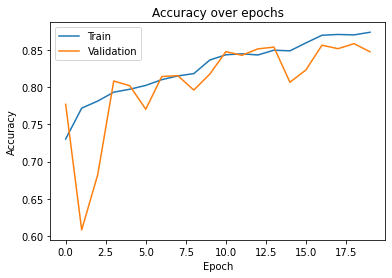

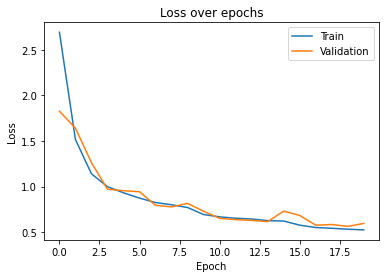

In [147]:
# Let us plot the results:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
# 20 Epochs were not enough!
# Let's increase the picture resolution and let's try out different image augmentation techniques.
# Increasing the resolution should give the model more information to work with.

# After that let's build a custom prediction function where we take one picture, make several new pictures
# out of it through cropping, and than classify each of those pictures with our classifier.
# A vote will decide what the final classification will be.

In [7]:
#####
# fit the model
#####

history = model.fit(
                    train_generator, 
                    epochs = 30, 
                    validation_data = valid_generator,
                    callbacks=callbacks
                   ) 

Epoch 1/30
8559/8559 [==============================] - 4159s 486ms/step - loss: 1.9281 - accuracy: 0.6265 - val_loss: 1.1174 - val_accuracy: 0.6660
Epoch 2/30
8559/8559 [==============================] - 4176s 488ms/step - loss: 1.0942 - accuracy: 0.6658 - val_loss: 1.0990 - val_accuracy: 0.6401
Epoch 3/30
8559/8559 [==============================] - ETA: 0s - loss: 1.0204 - accuracy: 0.6714
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
8559/8559 [==============================] - 4210s 492ms/step - loss: 1.0204 - accuracy: 0.6714 - val_loss: 1.4448 - val_accuracy: 0.4959
Epoch 4/30
8559/8559 [==============================] - 4191s 490ms/step - loss: 0.9044 - accuracy: 0.6929 - val_loss: 1.0814 - val_accuracy: 0.6511
Epoch 5/30
8559/8559 [==============================] - ETA: 0s - loss: 0.8622 - accuracy: 0.7109
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
8559/8559 [==============================] - 4232s 494ms/st

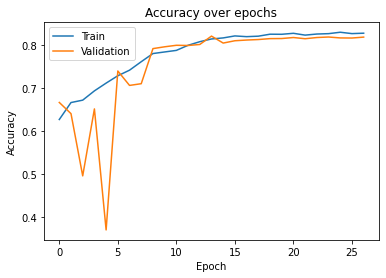

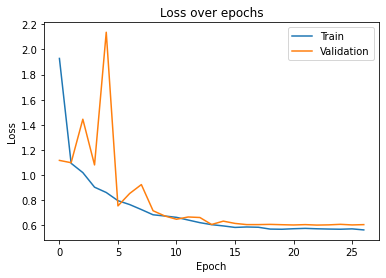

In [8]:
# Let us plot the results:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [1]:
#Ok this some work for my GPU :D
#Val_acc is slightly worse.
#But still... let's write our custom prediction function.